<a href="https://colab.research.google.com/github/aahincapie/DS-Env/blob/master/ForestLosses_CO2000_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primero debe sacar cuenta en https://code.earthengine.google.com/

Sobre los datos de cambio de cobertura arbórea de la U de Maryland (Hansen): https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2022_v1_10

Este código básico puede mejorarse, adaptarse y ajustarse a partir de indicaciones como las de https://developers.google.com/earth-engine/tutorials/community/forest-cover-loss-estimation

Sobre la precisión de los datos Hansen para Colombia: https://link.springer.com/article/10.1007/s10651-023-00571-w (spoiler: hay regiones donde son mejores que los datos de IDEAM)

Hasta 2019 IDEAM fue líder global en estimación de la deforestación, los datos IDEAM se validan en campo (donde las autoridades ambientales regionales CAR hacen la tarea) los datos Hansen no (no distinguen cultivos forestales, por ejemplo; IDEAM sí clasifica otras coberturas además de bosque)

CUATRO AÑOS lleva IDEAM Colombia sin publicar DATOS (pixeles) de bosque / no bosque http://www.ideam.gov.co/web/siac/geovisorconsultas incumpliendo la Ley de transparencia y del derecho de acceso a la información pública nacional (Ley 1712 de 2014)

Los datos 2022 de Hansen no coinciden con las cifras y gráficas con logos IDEAM y Visión Amazonía divulgadas por la ministra Susana Muhamad

In [1]:
!pip install earthengine-api
!pip install geemap
!pip install geopandas
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.5 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11125 sha256=864870572c5860cd7084c01712e7f35d2bd0169a910d538b3107a53efcc05bf0
  Stored in directory: /root/.cache/pip/wheels/04/24/fe/140a94a7f1036003ede94579e6b4227

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt

# Inicie Earth Engine
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=7IzxPl6HR_pv55rO2UESMIpiKsBt15ZG4P7BOswBon8&tc=nm067GhMR5RmaZ8bZ-_QNeHo0GpWG8oVOj5FHLDBKDc&cc=R7XDqIbBJgzBEnqP4KT7Yu00064WdJEYICQ0FjhqXQc

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BXEO4iBYSLe3K-JnL-i1nDVqrntI98h8XVrqvtte9jzOucUewuaRtw

Successfully saved authorization token.


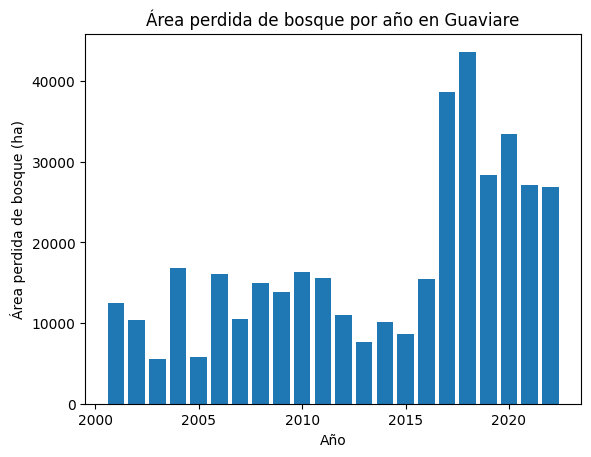

In [ ]:
# Escriba el departamento sin acentos
departamento = 'Guaviare'

# Carga de datos Global Forest Change
dataset = ee.Image('UMD/hansen/global_forest_change_2022_v1_10')

# Cargar datos GAUL nivel 2 para Colombia
paises = ee.FeatureCollection('FAO/GAUL/2015/level2')
colombia = paises.filter(ee.Filter.eq('ADM0_NAME', 'Colombia'))
selected = colombia.filter(ee.Filter.eq('ADM1_NAME', departamento))

# Calcular pérdida para cada año (2001 a 2022) y almacenar áreas perdidas
areas_perdidas = []  # Lista para almacenar áreas perdidas

for year in range(1, 23):
    # Seleccionar pixeles de cobertura arbórea perdida
    treeLossYear = dataset.select(['lossyear'])
    lossPixels = treeLossYear.eq(year).selfMask()

    # Applicar criterio de área mínima con connectedPixelCount
    contLoss = lossPixels.connectedPixelCount()
    minLoss = contLoss.gte(6).selfMask()

    # Calcular el área perdida (ha)
    lossArea = minLoss.multiply(ee.Image.pixelArea()).divide(10000)
    lossSize = lossArea.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=selected.geometry(),
        scale=30,
        maxPixels=1e13
    )

    # Almacenar el área perdida por año
    area_perdida = lossSize.get('lossyear')
    areas_perdidas.append(area_perdida.getInfo())

# Graficar pérdida anual
plt.bar(range(2001, 2023), areas_perdidas)
plt.xlabel('Año')
plt.ylabel('Área perdida de bosque (ha)')
plt.title(f'Área perdida de bosque por año en {departamento}')
plt.show()

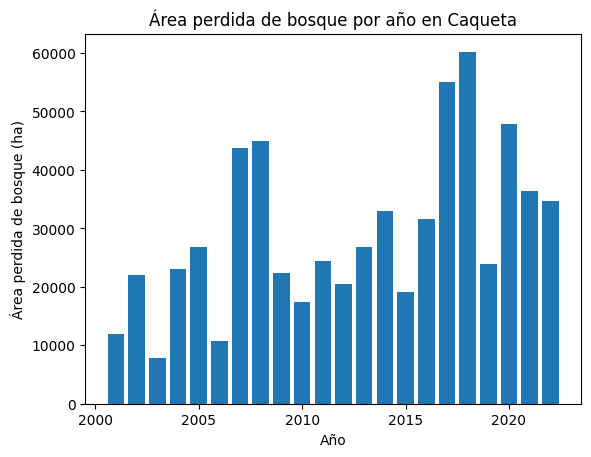

In [ ]:
departamento = 'Caqueta'

dataset = ee.Image('UMD/hansen/global_forest_change_2022_v1_10')

paises = ee.FeatureCollection('FAO/GAUL/2015/level2')
colombia = paises.filter(ee.Filter.eq('ADM0_NAME', 'Colombia'))
selected = colombia.filter(ee.Filter.eq('ADM1_NAME', departamento))

# Calculate forest loss for each year (2001 to 2022) and store the lost areas
areas_perdidas = []  # List to store the lost areas

for year in range(1, 23):
    # Select tree loss pixels for the current year
    treeLossYear = dataset.select(['lossyear'])
    lossPixels = treeLossYear.eq(year).selfMask()

    # Apply the minimum canopy cover percentage (e.g., greater than or equal to 10%)
    treeCover = dataset.select(['treecover2000'])
    canopyCover80 = treeCover.gte(80).selfMask()

    # Apply the minimum area requirement using connectedPixelCount
    contLoss = lossPixels.connectedPixelCount()
    minLoss = contLoss.gte(11).selfMask()

    # Combine the loss and canopy cover masks
    finalLoss = minLoss.updateMask(canopyCover80)

    # Calculate the forest loss area (ha)
    lossArea = finalLoss.multiply(ee.Image.pixelArea()).divide(10000)
    lossSize = lossArea.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=selected.geometry(),
        scale=30,
        maxPixels=1e13
    )

    # Store the forest loss area for the current year
    area_perdida = lossSize.get('lossyear')
    areas_perdidas.append(area_perdida.getInfo())

# Plot the forest loss areas by year
plt.bar(range(2001, 2023), areas_perdidas)
plt.xlabel('Año')
plt.ylabel('Área perdida de bosque (ha)')
plt.title(f'Área perdida de bosque por año en {departamento}')
plt.show()